# Selecting a location for an oil well
Imagine if we work in a production company "GlavRosGosNeft". As data sceintists we have to decide where to drill a new well.

We have the oil samples from three regions: each has 10,000 fields where you have measured the quality of the oil and the amount of oil reserves. So, let's build a machine learning model to help us to determine the region where production will yield the highest profit. We will analyze possible profits and risks using the *Bootstrap* technique.

Planned steps for selecting a location:

- In the selected region, look for deposits and determine feature values for each;
- Build a model and estimate the amount of reserves;
- Select the fields with the highest estimated values. The number of the fields depends on the company's budget and the cost for developing one well;
- Profit is equal to the total profit of the selected fields.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

## Data loading and preparation

Let's load the data and check if they are good.  
Since the information is the same everywhere, we will create a single dataset by adding information about the place of data collection.  
There are no gaps in the data.  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        100000 non-null  object 
 1   f0        100000 non-null  float64
 2   f1        100000 non-null  float64
 3   f2        100000 non-null  float64
 4   product   100000 non-null  float64
 5   location  100000 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 4.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   id        100000 non-null  object 
 1   f0        100000 non-null  float64
 2   f1        100000 non-null  float64
 3   f2        100000 non-null  float64
 4   product   100000 non-null  float64
 5   location  100000 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 4.6+ MB
<class 'pandas.cor

,id,f0,f1,f2,product,location
0,txEyH,0.705745,-0.497823,1.221170,105.280062,0
1,2acmU,1.334711,-0.340164,4.365080,73.037750,0
2,409Wp,1.022732,0.151990,1.419926,85.265647,0
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,0
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,0
5,wX4Hy,0.969570,0.489775,-0.735383,64.741541,0
6,tL6pL,0.645075,0.530656,1.780266,49.055285,0
7,BYPU6,-0.400648,0.808337,-5.624670,72.943292,0
8,j9Oui,0.643105,-0.551583,2.372141,113.356160,0
9,OLuZU,2.173381,0.563698,9.441852,127.910945,0


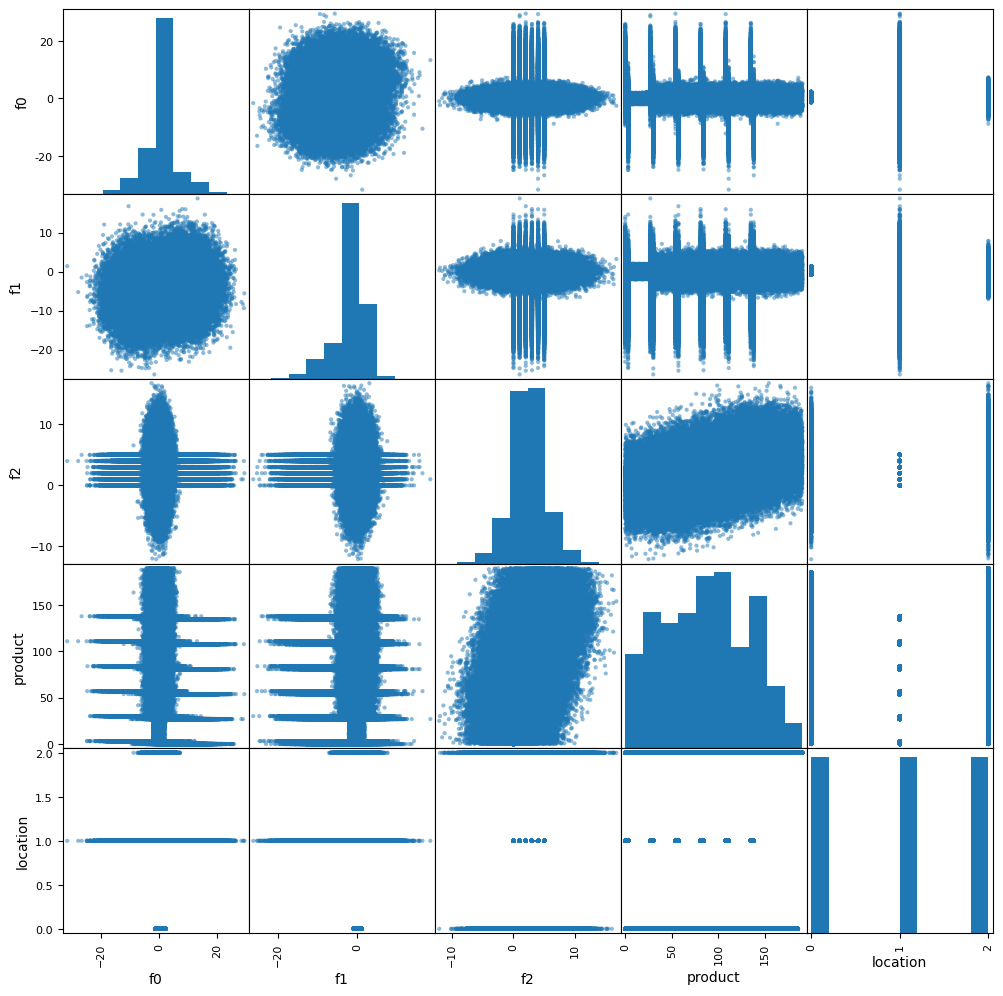

In [2]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    data_0 = pd.read_csv('C:/Users/Ivan/datasetsYP/geo_data_0.csv')
    data_1 = pd.read_csv('C:/Users/Ivan/datasetsYP/geo_data_1.csv')
    data_2 = pd.read_csv('C:/Users/Ivan/datasetsYP/geo_data_2.csv')    


data_0['location'] = 0
data_1['location'] = 1
data_2['location'] = 2

data_0.info()
data_1.info()
data_2.info()
data = pd.concat([data_0, data_1, data_2], axis = 0)
data.describe()

# Let's check the data for collenarity
print(data.corr(numeric_only=True))
pd.plotting.scatter_matrix(data, figsize=(12,12));

data.head(20)

**Data description:**  
id - unique identifier of the well;  
f0, f1, f2 - three point attributes (it does not matter what they mean, but the attributes themselves are significant);  
product - volume of reserves in the well (thousand barrels).    
Although there is no information about the parameters f0, f1, f2, apparently, the data have been previously worked with and normalized.    
No related data were also found on the general dataset.

## Model training and validation  
### Model Training
Considering to the problem conditions, only linear regression is suitable for model training (our boss considers other models as predictable enough). The following operations should be performed:  
 1. Split the data into training and validation samples in the ratio 75:25.  
 2. Train the model and make predictions on the validation sample.  
 3. Save the predictions and correct answers on the validation sample.  
 4. Print the average stock of the predicted raw and RMSE of the model on the screen.  
 

In [3]:
# Since we are interested in working with 4 different datasets, let's write a function that will perform
# Data preprocessing and model training and then call it for all 4 cases.

# A place to store the models, let's refer to the total data as 3

model_list = []
model_predictions = []
rsme_list = []
mean_list = []
mean_true = []

def machine_learning(data, place_identifier):
    global model_list
    global model_predictions
    global rsme_list
    global mean_list
    global mean_true
    to_drop = ['id', 'product', 'location']
    features = data.drop(to_drop, axis=1)
    targets = data['product']
    
    train_features, valid_features = train_test_split(
        features, test_size=0.25, random_state=44
    )

    train_targets, valid_targets = train_test_split(
        targets, test_size=0.25, random_state=44
    )
        
    model = LinearRegression()
    model.fit(train_features, train_targets)
    model_list.append(model)
    
    predictions = model.predict(valid_features)
    saved_predictions_and_true_values = pd.DataFrame({'predictions': predictions, 'valid': valid_targets})
    model_predictions.append(saved_predictions_and_true_values)

    rsme = mean_squared_error(valid_targets, predictions)**0.5 
    print(f'RSME for place {place_identifier}:', rsme)
    rsme_list.append(rsme)
    
    mean_product = predictions.mean()
    print(f'Calculated avarage raw material stock for {place_identifier}:', mean_product)
    mean_list.append(mean_product)
    mean_true.append(valid_targets.mean())
    
    print('\n')
    

In [4]:
machine_learning(data_0, 0)
machine_learning(data_1, 1)
machine_learning(data_2, 2)
machine_learning(data, 3)

RSME for place 0: 37.77268636795981
Calculated avarage raw material stock for 0: 92.46203438661259


RSME for place 1: 0.8857076441957266
Calculated avarage raw material stock for 1: 68.51920639719152


RSME for place 2: 40.10562308381635
Calculated avarage raw material stock for 2: 94.98365106986161


RSME for place 3: 38.83217275926211
Calculated avarage raw material stock for 3: 85.31295069787629




### Analyzing results, preliminary conclusions

,mean_true,mean_predicted,rsme
0,92.468371,92.462034,37.772686
1,68.521802,68.519206,0.885708
2,94.871996,94.983651,40.105623
3,85.269116,85.312951,38.832173


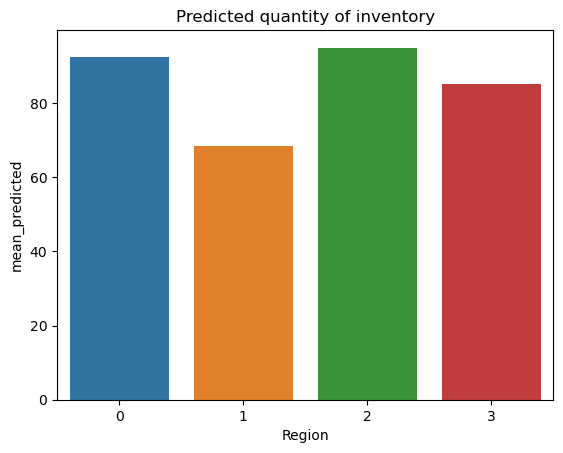

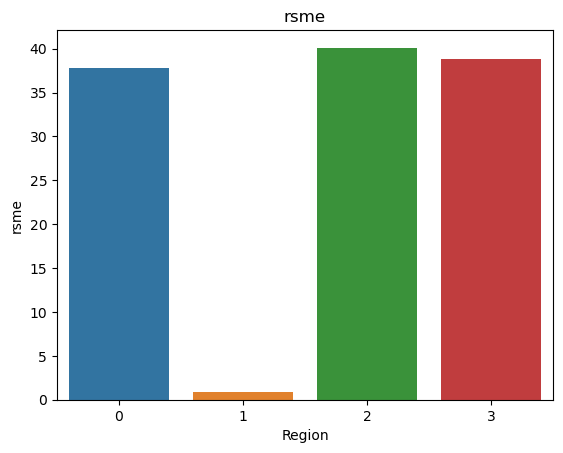

In [5]:
models_analysis = pd.DataFrame({'mean_true': mean_true, 'mean_predicted': mean_list, 'rsme': rsme_list})
display(models_analysis)

sns.barplot(x=models_analysis.index, y = models_analysis['mean_predicted']);
plt.title('Predicted quantity of inventory')
plt.xlabel('Region')
plt.show()
print('\n')
sns.barplot(x=models_analysis.index, y = models_analysis['rsme']);
plt.xlabel('Region')
plt.title('rsme')
plt.show()

It turned out that the predictive power of the regression at different sites is very different.  
Although the mean predicted by the model matches well the true mean for all cases, the root mean square deviation for plots 0 and 2 (and for the prediction for all fields together) is high, on the order of 30%.  
Whereas for the site 1 the RSME is very small.  
Although in average the fields are richer for sites 0 and 2, the value of the variance may be important for making decision.

## Preparation for profit calculation  
The following steps should be performed:  
 1. Store all key values for the calculations in separate variables.  
 2. Calculate sufficient raw material volume to break-even on the new well development.  
 3. Compare the resulting raw material volume with the average stock in each region.   
 4. Draw conclusions from the preparation step of the profit calculation.  
 **Parameter Information:**  
 When exploring a region, 500 points are investigated, from which the best 200 points are selected for development using machine learning.  
 The budget for well development in the region is 10 billion rubles.  
At current prices, one barrel of raw materials generates 450 rubles in revenue. Income from each unit of the product is 450 thousand rubles, since the volume is specified in thousands of barrels.
 

In [6]:
# Number of piles that will be in operation
N_WELLS = 200

# Total budget
TOTAL_SPENDS = 10**10

# Revenue per unit of the product
INCOME_PER_UNIT = 450000

# The cost per well and its payback period
spending_per_wells = TOTAL_SPENDS / N_WELLS
min_profitable_oil = spending_per_wells / INCOME_PER_UNIT
print(f'''The costs per well are as follows {spending_per_wells}, 
      and it should have minimal reserves {min_profitable_oil} for payback''')

# Let's compare the required stock with the average of the true and predicted values
models_analysis['predicted_mean_more_then_needed'] = models_analysis['mean_predicted'] > min_profitable_oil 
models_analysis['true_mean_more_then_needed'] = models_analysis['mean_true'] > min_profitable_oil
display(models_analysis)

The costs per well are as follows 50000000.0, 
      and it should have minimal reserves 111.11111111111111 for payback


,mean_true,mean_predicted,rsme,predicted_mean_more_then_needed,true_mean_more_then_needed
0,92.468371,92.462034,37.772686,False,False
1,68.521802,68.519206,0.885708,False,False
2,94.871996,94.983651,40.105623,False,False
3,85.269116,85.312951,38.832173,False,False


According to calculations, the average oil reserve required for break-even development of 200 wells is 111.(1) thousand barrels.  
This condition does not meet in average by any of the regions, both as predicted and as true.  
However, since only the richest fields are being developed, it is likely to pay off, if this rich places are predicted correctly.

## Function for profit calculation
We need to write a function to calculate profit on selected wells and model predictions:  
 1. Select wells with maximum predictions.   
 2. Sum the target raw material volume value corresponding to these predictions.  
 3. Calculate the profit for the resulting raw material volume.

,gain
0,4014.371393
1,2423.475917
2,3387.105867
3,5300.321229


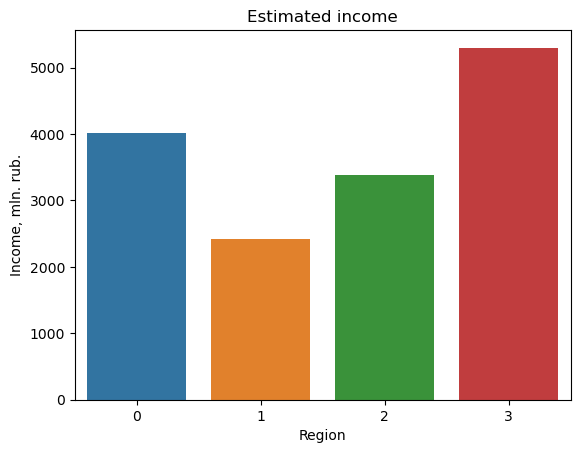

In [7]:
# Function for calculating profit on predictions
def profit(region_number):    
    global model_predictions
    global INCOME_PER_UNIT
    global TOTAL_SPENDS
    
    # Select and sort in descending order the data from the prediction dataset
    needed_predictions = model_predictions[region_number]['predictions']
    needed_predictions = needed_predictions.sort_values(ascending=False)
    
    # Calculate profit: sum the first 200 predictions, subtract development costs
    total_oil = needed_predictions[:199].sum()
    total_gain = total_oil * INCOME_PER_UNIT - TOTAL_SPENDS
    total_gain /= 10**6

    return total_gain

profit_list = []
for i in range(0, 4, 1):
    profit_list.append(profit(i))

predicted_profit = pd.DataFrame({'gain': profit_list})
display(predicted_profit)

sns.barplot(x=predicted_profit.index, y = predicted_profit['gain']);
plt.xlabel('Region')
plt.ylabel('Income, mln. rub.')
plt.title('Estimated income')
plt.show()

Indeed, while in average no wells have broken even in any region, the best wells allow for break-even production in any region.

## Calculating Profit and Risks  

 Let's calculate the risks and profits for each region. For this purpose:  
 1. Apply the Bootstrap technique with 1000 samples to find the profit distribution.  
 2. Find the average profit, 95% confidence interval and the risk of loss. A loss is a negative profit.  
 3. Write a conclusion: suggest a region for well development and justify the choice.  
 After assessing the risks, you should keep only those regions where the probability of loss is less than 2.5%. Among them, select the region with the highest average profit.

,mean_profit,losing_money_probability,lower,upper
0,363.838838,10.3,-172.085092,888.777396
1,456.473289,1.7,48.000516,872.255600
2,278.478494,16.1,-285.483434,824.263947


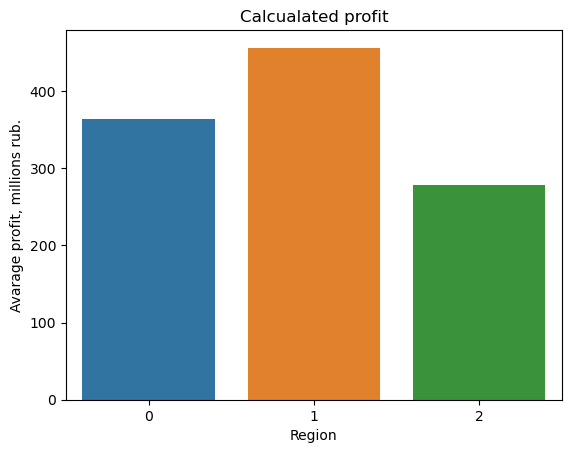

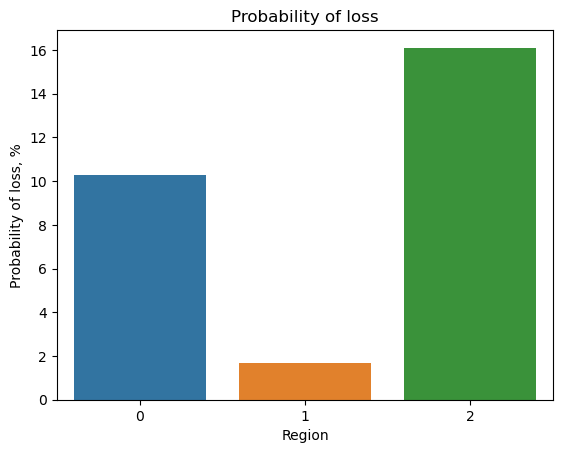

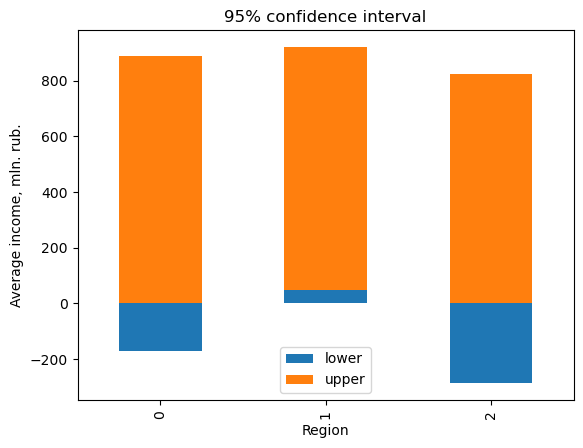

In [8]:
state = np.random.RandomState(44)

# Function for calculating real profits based on indexes from predictions
def real_profit(target, predictions):
    # Sort the data from the prediction dataset in descending order
    probs_sorted = predictions.sort_values(ascending=False)
    
    # Calculate profit: sum the first 200 predictions, subtract development costs
    total_oil = target[probs_sorted.index][:199].sum()
    total_gain = total_oil * INCOME_PER_UNIT - TOTAL_SPENDS
    total_gain /= 10**6
    
    return total_gain

bootstrap_results = pd.DataFrame({'mean_profit': [0], 'losing_money_probability': [0], 'lower': [0], 'upper': [0]},
                                 index=range(3))

for region in range(0, 3, 1):
    profit_bootstrap = []
    
    for i in range(1000):
        # sampling of 500 values according to the problem condition
        target_subsample = model_predictions[region]['valid'].sample(n=500, replace=True, random_state=state)
        probs_subsample = model_predictions[region]['predictions'][target_subsample.index]
        
        profit_bootstrap.append(real_profit(target_subsample, probs_subsample))
        
    # define the boundaries of the interval
    profit = pd.Series(profit_bootstrap)
    lower = profit.quantile(0.025)
    upper = profit.quantile(0.975)
    
    # record the results - average value, number of values less than zero (probability of loss), 
    # and 95% interval
    bootstrap_results['mean_profit'][region] = profit.mean()
    bootstrap_results['losing_money_probability'][region] = 100*(profit < 0).mean()
    bootstrap_results['lower'][region] = lower
    bootstrap_results['upper'][region] = upper

display(bootstrap_results)

# Visualize the average income by bootstrap method
sns.barplot(x=bootstrap_results.index, y = bootstrap_results['mean_profit']);
plt.xlabel('Region')
plt.ylabel('Avarage profit, millions rub.')
plt.title('Calcualated profit')
plt.show()

# Visualize the probability of loss
sns.barplot(x=bootstrap_results.index, y = bootstrap_results['losing_money_probability']);
plt.xlabel('Region')
plt.ylabel('Probability of loss, %')
plt.title('Probability of loss')
plt.show()

# Visualize the 95% confidence interval
bootstrap_results.plot(
          y = ['lower', 'upper'], 
          kind='bar', 
          stacked=True)
plt.xlabel('Region')
plt.ylabel('Average income, mln. rub.')
plt.title('95% confidence interval')
plt.show()

### Conclusions
**The only region suitable for development is 1.**  
According to the conditions, the probability of loss should be less than 2.5%, in the case of region 1, it is 1%.  
In this case, it probably played a role that the model predicts this region well with a very small mean square deviation. Therefore, even though the average stock is smaller in this region, the reliability of the data compensates for this. The average profit was also maximized for region 1.